![head.png](https://github.com/iwh-halle/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Getting started

See:
* https://vectorbt.dev/api/utils/docs/
* https://vectorbt.dev/getting-started/resources/
* https://github.com/polakowo/vectorbt

In [15]:
#!pip install vectorbt  # (You might need to install vectorbt)

import vectorbt as vbt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We need some historical data for our backtest. For this example we will use **data/TSLA.csv**.

In [16]:
tsla_ohlc = pd.read_csv("data/TSLA.csv", index_col=0, parse_dates=True)
# Convert the timestamp column to datetime format
tsla_ohlc["timestamp"] = pd.to_datetime(tsla_ohlc["timestamp"])
# Set timestamp as index
tsla_ohlc.set_index("timestamp", inplace=True)

display(tsla_ohlc.head())

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-01-03 05:00:00+00:00,118.47,118.80,104.6400,108.10,235727017.0,2540115.0,109.133537
2023-01-04 05:00:00+00:00,109.11,114.59,107.5200,113.64,183641524.0,1652357.0,111.901725
2023-01-05 05:00:00+00:00,110.51,111.75,107.1601,110.34,160906940.0,1337246.0,109.552300
2023-01-06 05:00:00+00:00,103.00,114.39,101.8100,113.06,224113076.0,2008686.0,109.418991
2023-01-09 05:00:00+00:00,118.96,123.52,117.1100,119.77,194213551.0,1740778.0,121.155910


## A simple Moving Average Crossover Strategy

We construct a simple trend-following system based on two Simple Moving Averages (SMAs) of the closing price $C_t$, each with a different window length $N$.

The **Simple Moving Average** at time $t$ with window $N$ is defined as:
$$
\text{SMA}_t(N) = \frac{1}{N} \sum_{j=t-N+1}^{t} C_j
$$

In our strategy:
- The **fast (short) moving average** uses a smaller window $N_f$ (e.g., $N_f = 20$).
- The **slow (long) moving average** uses a larger window $N_s$ (e.g., $N_s = 50$).

Typically, we have $N_f < N_s$.


In [17]:
# Compute two simple moving averages: fast (20-day) and slow (50-day)
ma_fast = tsla_ohlc['close'].rolling(window=20).mean()
ma_slow = tsla_ohlc['close'].rolling(window=50).mean()

# Just some plotting to visualize the idea
fig_ma = plt.figure(figsize=(10, 4))
plt.plot(tsla_ohlc['close'], label='Close')
plt.plot(ma_fast, label=f'Fast SMA')
plt.plot(ma_slow, label=f'Slow SMA')
plt.legend()
plt.close()

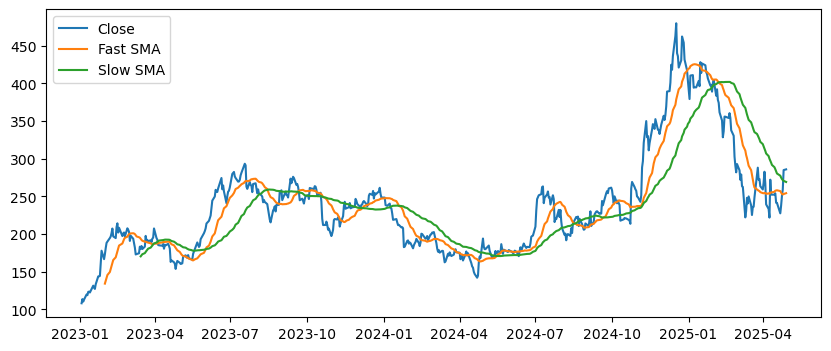

In [18]:
display(fig_ma)

### Entry and Exit Signals

We generate discrete "buy" and "sell" signals by detecting crossovers of the two SMAs:

- **Entry signal** (go long) at time $t$ when the fast SMA crosses **above** the slow SMA:
$$
\text{entry}_t = 
\begin{cases}
1, & \text{if } \text{SMA}_t(N_f) > \text{SMA}_t(N_s) \;\; \text{and} \;\; \text{SMA}_{t-1}(N_f) \leq \text{SMA}_{t-1}(N_s), \\
0, & \text{otherwise.}
\end{cases}
$$

- **Exit signal** (close position) at time $t$ when the fast SMA crosses **below** the slow SMA:
$$
\text{exit}_t = 
\begin{cases}
1, & \text{if } \text{SMA}_t(N_f) < \text{SMA}_t(N_s) \;\; \text{and} \;\; \text{SMA}_{t-1}(N_f) \geq \text{SMA}_{t-1}(N_s), \\
0, & \text{otherwise.}
\end{cases}
$$

In [19]:
# Entry when fast MA crosses above slow MA:
entries = (ma_fast > ma_slow) & (ma_fast.shift(1) <= ma_slow.shift(1))
#  Exit when fast MA crosses below slow MA:
exits = (ma_fast < ma_slow) & (ma_fast.shift(1) >= ma_slow.shift(1))

### Backtest Mechanics

This is a very simple backtest using the following parameters:

1. **Initial capital**: $C_0 = \text{USD}\ 100{,}000$
2. **Position sizing**: Fully invest all available capital at each entry; liquidate the entire position at each exit
3. **Transaction costs**: A round-trip transaction fee of $0.1\%$ is applied per completed trade (entry and exit)
4. **Performance metrics**: After running the backtest we can assess the strategy using vectorbt's risk and return metrics

Please note that this is just a simplified example. A very important component of a serious strategy is **position sizing** -- typically one would not invest all available capital into one asset. Speaking of, vectorbt is well capable to backtest strategies using multiple assets.

In [20]:
# Backtest via Portfolio.from_signals
pf = vbt.Portfolio.from_signals(
    tsla_ohlc['close'],
    entries,
    exits,
    init_cash=100000,
    freq='1D',
    fees=0.001
)

# 5. Inspect performance
print(pf.stats())

Start                         2023-01-03 05:00:00+00:00
End                           2025-04-28 04:00:00+00:00
Period                                581 days 00:00:00
Start Value                                    100000.0
End Value                                 138040.335626
Total Return [%]                              38.040336
Benchmark Return [%]                         164.458834
Max Gross Exposure [%]                            100.0
Total Fees Paid                              972.236252
Max Drawdown [%]                              46.446868
Max Drawdown Duration                 349 days 00:00:00
Total Trades                                          5
Total Closed Trades                                   5
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       60.0
Best Trade [%]                                44.403352
Worst Trade [%]                              -19

In [21]:
# 6. Plot equity curve
pf.plot().show()

### A comment on trade execution

The **biggest enemy of all backtests is look-ahead bias**. That is, you must never execute a trade based on information that became available after the time you are trading. The backtest above is not ideal, because we create signals and trade on the same information at time $t$. So, the signal based on $\text{Close}_{t}$ is executed and evaluated on $\text{Close}_{t}$.

As a solution, we could execute the signal based on $\text{Close}_{t-1}$ at $\text{Close}_{t}$; this can be achieved by calling `.shift(1)` on all signals. Please note that for our daily data there is a **24-hour gap between signal generation and trade execution**; this is conservative but not very realistic. Especially in shorter time intervals, it can be ideal to produce signals on $\text{Close}_{t-1}$ but trade and evaluate on $\text{Open}_{t}$.

Alternatively, especially for low-frequency data, one could assume that the signal is generated at a price very close to $\text{Close}_{t}$, while **accounting for slippage**.  
$$
\text{Slippage}_t = \frac{P^{\rm Trade}_t \;-\; P^{\rm Signal}_t}{P^{\rm Signal}_t}
$$  
In real or paper trading, one would store both the $P^{\rm Signal}_t$ as well as $P^{\rm Trade}_t$ and measure slippage continuously. This is particularly important for strategies trading large amounts, because market impact of the trade itself might create slippage. By the way, you could also explicitly provide the trade price as `price=...`.

In the following example we assume slippage of 2 basis points (0.02%), the true value depends heavily on the market and can ultimately only be assessed though actual trading.


In [22]:
# Backtest
pf = vbt.Portfolio.from_signals(
    tsla_ohlc['close'], 
    entries,
    exits,
    fees=0.001,
    slippage=0.0002, # 0.02% slippage on every fill
    init_cash=100000,
    freq='1D'
)

# Compare this to the performance of the original backtest
print(pf.stats())

Start                         2023-01-03 05:00:00+00:00
End                           2025-04-28 04:00:00+00:00
Period                                581 days 00:00:00
Start Value                                    100000.0
End Value                                 137764.530847
Total Return [%]                              37.764531
Benchmark Return [%]                         164.458834
Max Gross Exposure [%]                            100.0
Total Fees Paid                              971.247027
Max Drawdown [%]                              46.511093
Max Drawdown Duration                 349 days 00:00:00
Total Trades                                          5
Total Closed Trades                                   5
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       60.0
Best Trade [%]                                44.345562
Worst Trade [%]                              -19

# A slightly more advanced example

To spice things up, we will use a two-asset portfolio. Hence we load data from AAPL as well.

In [23]:
#%% Load AAPL data
aapl_ohlc = pd.read_csv("data/AAPL.csv", index_col=0, parse_dates=True)
# Convert the timestamp column to datetime format
aapl_ohlc["timestamp"] = pd.to_datetime(aapl_ohlc["timestamp"])
# Set timestamp as index
aapl_ohlc.set_index("timestamp", inplace=True)

I have also saved weather data for New York City from [NOAA](https://www.ncei.noaa.gov/cdo-web/search) in **data/weather_nyc.csv**

In [24]:
#%% Some data preparation
weather = pd.read_csv("data/weather_manhattan.csv", index_col=0)
# We are only interested in rain for now
weather = weather[["DATE", "PRCP"]]
# Remove duplicate in DATE and keep first occurrence
weather = weather.drop_duplicates(subset=["DATE"], keep="first")
# Convert the date string column to datetime format (compatibility with the OHLC data)
weather["DATE"] = pd.to_datetime(weather["DATE"]).dt.date
# Convert PRCP to float
weather["PRCP"] = weather["PRCP"].astype(float)

In [25]:
#%% We use aapl to carry over the precipitation data (aligning indices)
aapl_weather = aapl_ohlc.copy()
aapl_weather["date"] = aapl_ohlc.index.date
# Combine aapl and weather data (on date)
aapl_weather = pd.merge(aapl_weather, weather[["DATE", "PRCP"]], left_on="date", right_on="DATE", how="left")
# Re-create timestamp index
aapl_weather.index = aapl_ohlc.index
# Fill NaN values with 0 (no rain)
aapl_weather["PRCP"] = aapl_weather["PRCP"].fillna(0)

In [26]:
# Lets combine everything for simplicity
strategy_data = pd.DataFrame({
    'AAPL_close': aapl_ohlc['close'],
    'TSLA_close': tsla_ohlc['close'],
    'precipitation': aapl_weather['PRCP'],
}).sort_index().dropna()
display(strategy_data)

,AAPL_close,TSLA_close,precipitation
timestamp,,,
2023-01-03 05:00:00+00:00,125.145,108.10,10.7
2023-01-04 05:00:00+00:00,126.390,113.64,0.5
2023-01-05 05:00:00+00:00,125.030,110.34,0.3
2023-01-06 05:00:00+00:00,129.560,113.06,6.9
2023-01-09 05:00:00+00:00,130.180,119.77,0.3
...,...,...,...
2025-04-22 04:00:00+00:00,199.560,237.97,0.0
2025-04-23 04:00:00+00:00,204.330,250.74,0.0
2025-04-24 04:00:00+00:00,208.200,259.51,0.0


## Building a strategy for portfolio weights

We rotate a portfolio  between TSLA and AAPL based on whether it’s raining. We therefore determine portfolio weights $w_t$ for both stocks as 

  $$
    w^{\mathrm{TSLA}}_t =
    \begin{cases}
      1, & \text{if } \mathrm{precipitation}_t > 0,\\
      0, & \text{otherwise.}
    \end{cases}
  $$

and

$$
w^{\mathrm{AAPL}}_t = 1 - w^{\mathrm{TSLA}}_t
$$

The economic rational behind this strategy is obvious.

In [27]:
# Create rainy day indicator
strategy_data["rainy"] = strategy_data["precipitation"] > 0.0

# Calculate portfolio weights
weights = pd.DataFrame(index=strategy_data.index)
weights['TSLA'] = np.where(strategy_data["rainy"], 1, 0)
weights['AAPL'] = np.where(strategy_data["rainy"], 0, 1)

# Assert that weights sum up to 1 for all rows
assert (weights.sum(axis=1) == 1).all(), "Weights do not sum to 1 for all rows"

display(weights)

,TSLA,AAPL
timestamp,,
2023-01-03 05:00:00+00:00,1,0
2023-01-04 05:00:00+00:00,1,0
2023-01-05 05:00:00+00:00,1,0
2023-01-06 05:00:00+00:00,1,0
2023-01-09 05:00:00+00:00,1,0
...,...,...
2025-04-22 04:00:00+00:00,0,1
2025-04-23 04:00:00+00:00,0,1
2025-04-24 04:00:00+00:00,0,1


In [28]:
from vectorbt.portfolio.enums import SizeType, Direction

# Let's run the actual backtest
pf = vbt.Portfolio.from_orders(
    close=strategy_data[["AAPL_close", "TSLA_close"]],
    size=weights,                   # DataFrame of target weights (summing to 1 across columns)
    size_type=SizeType.TargetPercent,  # See weights
    direction=Direction.LongOnly,   # only go long according to your weights
    call_seq='auto',                # sell first, then buy
    group_by=True,                  # one shared‐cash group
    cash_sharing=True,              # share cash across both legs
    init_cash=100000,               # starting capital
    fees=0.001,                     # 0.1% round‐trip
    slippage=0.0002,                # 0.02% slippage on every fill
    freq='1D'                       # daily data
)

# Quick look:
print(pf.stats())
pf.plot().show()

Start                         2023-01-03 05:00:00+00:00
End                           2025-04-28 04:00:00+00:00
Period                                581 days 00:00:00
Start Value                                    100000.0
End Value                                 180568.639778
Total Return [%]                               80.56864
Benchmark Return [%]                         116.164053
Max Gross Exposure [%]                            100.0
Total Fees Paid                            56354.380667
Max Drawdown [%]                              54.894177
Max Drawdown Duration                 320 days 00:00:00
Total Trades                                        214
Total Closed Trades                                 213
Total Open Trades                                     1
Open Trade PnL                             27816.774354
Win Rate [%]                                  53.521127
Best Trade [%]                                35.605753
Worst Trade [%]                              -21

c:\Users\nb\anaconda3\envs\algo-trading\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\nb\anaconda3\envs\algo-trading\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data

